# Visualizações e pré-processamento

Este notebook é utilizado tanto para visualização quanto pré-processamento dos dados de entrada.

### Imports e configurações iniciais

In [2]:
# If necessary
%pip install wordcloud
%pip install stanza

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 435 kB 12.5 MB/s            
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 691 kB 28.6 MB/s            
     |████████████████████████████████| 240 kB 57.7 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 881.9 MB 5.0 kB/s              
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234906 sha256=fab68004b174a9df2b5cce4c1b4c59b44ebf6aa6efbeae89a26f03e19808f497
  Stored in directory: /home/ec2-user/.cache/pip/wheels/20/ae/c3/a0104b9bcd7396b30ea031e758ff74ab197e63f203e895ad69
Successfully built emoji
Note: you may need to restart the kernel to use updated packages.


In [52]:
import nltk
import numpy as np
import stanza
from wordcloud import WordCloud
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# from unidecode import unidecode
from sklearn.base import BaseEstimator, TransformerMixin
import boto3
nltk.download('all', quiet=True)
stanza.download('pt', verbose=False)

### Definições de funções úteis

In [4]:
def plot_cloud(words_string):
    """
    Função para plotar nuvem de palavras
    """
    nuvem_palavras = WordCloud(width= 1000, height= 800, max_font_size = 110, collocations= False).generate(words_string)
    plt.figure(figsize=(12,8))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
def plot_word_counts(tokens, n=10):
    """
    Função para plotar gráfico com contagens das 'n' palavras mais comuns presentes nos 'tokens'
    """
    frequency = nltk.FreqDist(tokens)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                 "Frequency": list(frequency.values())})
    plt.figure(figsize=(16,8))
    ax = sns.barplot(data = df_frequency.sort_values(by=['Frequency'], ascending=False).head(n), x = "Word", y = "Frequency")
    ax.set(ylabel = "Count")
    plt.show()

### Visualizações com dados crus

In [5]:
bucket = 'projetointerdisciplinardadosbrutos'
file_name = 'dados_brutos.csv'
raw_data = pd.read_csv(f's3://{bucket}/{file_name}')
raw_data.head()

,fake,text
0,0,A divisão do STF ao meio entre partidários e ...
1,1,"General manda recado para STF: ""Abaixaram as c..."
2,1,O Nordeste acordou! Lula e o PT são enxotados:...
3,0,"Dois relatórios da Polícia Federal, com análi..."
4,1,Coreia do Norte declara status de QUASE-GUERRA...


In [6]:
raw_words =' '.join([text for text in raw_data.text])

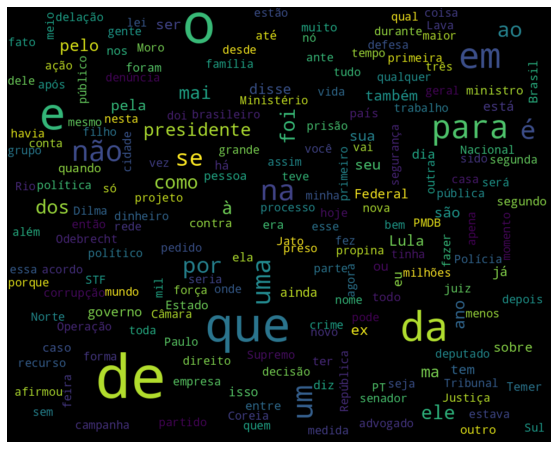

In [7]:
plot_cloud(raw_words)

Como é de se esperar, as contagens de palavras são dominadas por stopwords, palavras com pouco significado para os textos. 

### Visualização com dados processados

Para uma análise mais eficaz, é necessário eliminar as stopwords. Durante esta limpeza, também serão removidos sinais de pontuação, acentos e outros caracteres especiais e todas as palavras serão padronizadas para utilizar letras minúsculas apenas. Após esta limpeza, será feita uma nova visualização dos dados.

In [190]:
def tokenize_text_and_get_stats(df_row, nlp_pipeline, stopword_list=None):
    """
    Função para tokenizar um texto localizado em uma linha de um DataFrme. 
    Texto deve etar na coluna 'text'
    Retorna uma tupla com 4 valores:
    - Word_list (tokens de palavras, excluindo stopwords)
    - Lemma_list (tokens de lemmas das palavras, desde que a palavra original não seja stopword)
    - Tamanho médio de frases do texto (em palavras, excluindo stopwords e pontuação)
    - Tamanho médio de palavras no texto (excluindo stopwords e pontuação)
    """
    if stopword_list is None:
        stopword_list = []
    
    text = df_row['text']
    processed = nlp_pipeline(text)
    word_list = []
    lemma_list = []

    word_avg_lengths = []

    sentence_lengths = []
    for sent in processed.sentences:
        local_word_list = []
        for word in sent.words:
            if word.text.lower() in stopword_list or word.pos == 'PUNCT':
                continue
            local_word_list.append(word.text)
            lemma_list.append(word.lemma)
            word_lengths.append(len(word.text))

        sentence_lengths.append(len(local_word_list))

        word_list.extend(local_word_list)
        avg_word_len = np.mean(word_lengths)
        word_avg_lengths.append(avg_word_len)
    
    return word_list, lemma_list, np.mean(sentence_lengths), np.mean(word_avg_lengths)

In [205]:
def create_tokenized_df(base_df, remove_nao=True):
    """
    Função para criar colunas no DataFrame referentes à tokenização
    """
    if 'text' not in base_df.columns:
        return base_df
    
    df = base_df.copy()
    nlp = stanza.Pipeline('pt', processors='tokenize,mwt,pos,lemma')
    stopwords = nltk.corpus.stopwords.words('portuguese')
    if remove_nao:
        stopwords.remove('não')
    stopwords.append('r')
    df[['words', 'lemmas', 'avg_sent_len', 'avg_word_len']] = df.apply(tokenize_text_and_get_stats, axis=1,
                                                                       result_type='expand',
                                                                       stopword_list=stopwords,
                                                                       nlp_pipeline=nlp)
    return df

In [11]:
processed_df = create_tokenized_df(base_df)

In [12]:
processed_words = ' '.join([row for row in processed_df['text']])

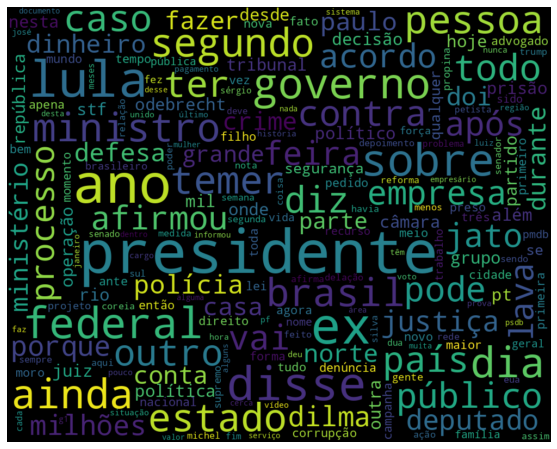

In [13]:
plot_cloud(processed_words)

In [ ]:
token_phrases = nltk.word_tokenize(processed_words)

In [ ]:
plot_word_counts(token_phrases, n=15)

Com o pré-processamento, nota-se que restam palavras mais significativas nos textos. Em particular, nota-se que os textos da base parecem enfatizar assuntos políticos.

Os dados pré-processados são então salvos para que possam ser utilizados no treinamento e validação de modelos.

In [21]:
processed_file = 'dados_processados.csv'
processed_bucket = 'projetointerdisciplinardadosprocessados'

processed_df.to_csv(processed_file, encoding='utf-8', index=False)
s3 = boto3.resource('s3')
with open(processed_file, 'rb') as f:
    s3.Bucket(processed_bucket).put_object(Key=processed_file, Body=f)